In [3]:
%pip install -q -U --pre triton
%pip install -q accelerate==0.20.3 transformers torchmetrics diffusers datasets torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [10]:
!pip install super-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 1.9 MB/s eta 0:00:00


In [35]:
import torch
from torchmetrics.functional.multimodal import clip_score
from functools import partial
from diffusers import StableDiffusionPipeline
import numpy as np
from transformers import CLIPProcessor, CLIPModel, CLIPImageProcessor, CLIPTokenizer
from torchvision import transforms as transforms
from datasets import load_dataset
from PIL import Image
from super_image import A2nModel,HanModel

In [124]:
device = torch.device("cuda:0")
resize_model = A2nModel.from_pretrained('eugenesiow/a2n', scale=4)
#resize_model = HanModel.from_pretrained('eugenesiow/han', scale=2)
resize_model = resize_model.to(device)
resize = transforms.Resize((224,224))
resize_ = transforms.Resize((512,512))
def upsample(img):
    img = img.to(device)
    new_img = resize_model(img)
    new_img = resize_(new_img)
    return new_img.detach().cpu()

https://huggingface.co/eugenesiow/a2n/resolve/main/pytorch_model_4x.pt


In [22]:
ex = torch.ones((1,3,224,224))
print(upsample(ex).shape)

torch.Size([1, 3, 512, 512])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [137]:
from torchmetrics.utilities import rank_zero_warn
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")
device = torch.device("cuda:0")
def refine_image(image, prompt, clip_model, learning_rate=0.3):
    clip_model = clip_model.to(device)
    if len(image.shape)!=4:
        image = np.reshape(image,(1,*image.shape))
    image = torch.from_numpy(image)
    imgprocessor = CLIPImageProcessor(do_resize=False).from_pretrained("openai/clip-vit-base-patch16")
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")
    processor = CLIPProcessor(imgprocessor,tokenizer).from_pretrained("openai/clip-vit-base-patch16")
    inputs = processor(text=prompt, return_tensors="pt", padding=True)
    if image.shape[1]!=3:
        image = image.permute(0,3,1,2)
    if image.shape[2]!=224:
        image = resize(image)
    image.requires_grad_(True)
    img_features = clip_model.get_image_features(image.to(device))
    img_features = img_features / img_features.norm(p=2, dim=-1, keepdim=True)
    max_position_embeddings = clip_model.config.text_config.max_position_embeddings
    if inputs["attention_mask"].shape[-1] > max_position_embeddings:
        rank_zero_warn(
            f"Encountered caption longer than {max_position_embeddings=}. Will truncate captions to this length."
            "If longer captions are needed, initialize argument `model_name_or_path` with a model that supports"
            "longer sequences",
            UserWarning,
        )
        inputs["attention_mask"] = inputs["attention_mask"][..., :max_position_embeddings]
        inputs["input_ids"] = inputs["input_ids"][..., :max_position_embeddings]

    txt_features = clip_model.get_text_features(
        inputs["input_ids"].to(device), inputs["attention_mask"].to(device)
    )
    txt_features = txt_features / txt_features.norm(p=2, dim=-1, keepdim=True)
    score = 100 * (img_features * txt_features).sum(axis=-1)
    # Backward pass to compute gradient of CLIP score wrt image
    clip_model.zero_grad()
    image.retain_grad()
    score.backward()
    # Update the image by gradient ascending
    new_image = image + learning_rate * image.grad
    image.requires_grad_(False)
    #new_image = upsample(new_image)
    new_image = resize_(new_image)
    new_image = new_image.squeeze(0)
    new_image = new_image.permute(1,2,0)
    new_image = new_image.cpu().detach().numpy()
    if np.max(new_image)>1:
        new_image = new_image/np.max(new_image)
    new_image[new_image < 0] = 0
    return new_image


def calculate_clip_score(images, prompts):
    if len(images.shape)!=4:
        images = np.reshape(images,(1,*images.shape))
    if isinstance(images, np.ndarray):
        images = torch.from_numpy(images)
    clip_score = clip_score_fn((images).permute(0, 3, 1, 2), prompts).detach().cpu()
    return clip_score

In [23]:
#Eval Code
model_ckpt = "runwayml/stable-diffusion-v1-5"
sd_pipeline = StableDiffusionPipeline.from_pretrained(model_ckpt, torch_dtype=torch.float16).to("cuda")

sd_pipeline.safety_checker = None
#Fix seed for comparison
seed = 1
generator = torch.manual_seed(seed)
CLIPSCORES = []
for j in range(20):
    prompts = load_dataset("nateraw/parti-prompts", split="train")
    prompts = [prompts[5*j+i]["Prompt"] for i in range(5)]
    images = sd_pipeline(prompts, num_images_per_prompt=1, generator=generator, output_type="np").images
    CLIP_scores_0 = calculate_clip_score(images,prompts)
    CLIP_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
    images_3 = []
    images_6 = []
    for i,image in enumerate(images):
        image = refine_image(image,prompts[i],CLIP_model)
        image = refine_image(image,prompts[i],CLIP_model)
        image = refine_image(image,prompts[i],CLIP_model)
        images_3.append(image)
        image = refine_image(image,prompts[i],CLIP_model)
        image = refine_image(image,prompts[i],CLIP_model)
        image = refine_image(image,prompts[i],CLIP_model)
        images_6.append(image)
    images_3 = np.stack(images_3,0)
    images_6 = np.stack(images_6,0)
    CLIP_scores_1 = calculate_clip_score(images_3,prompts)
    CLIP_scores_2 = calculate_clip_score(images_6,prompts)
    CLIPSCORES.append((CLIP_scores_0.item(),CLIP_scores_1.item(),CLIP_scores_2.item()))

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
CLIPSCORES
mean_scores = [sum(values) / len(values) for values in zip(*CLIPSCORES)]
mean_scores

[23.63835973739624, 24.020499801635744, 24.028654670715333]

In [143]:
# Show an example image
random_num = np.random.randint(100,1000)
prompts = load_dataset("nateraw/parti-prompts", split="train")
prompt = prompts[random_num]["Prompt"]
print(prompt)
image = sd_pipeline(prompt, num_images_per_prompt=1, generator=generator, output_type="np").images
score_0 = calculate_clip_score(image,prompt)
CLIP_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
image_0 = image
image = refine_image(image,prompt,CLIP_model)
#image = refine_image(image,prompt,CLIP_model)
#image = refine_image(image,prompt,CLIP_model)
image_3 = image
#image = refine_image(image,prompt,CLIP_model)
#image = refine_image(image,prompt,CLIP_model)
image = refine_image(image,prompt,CLIP_model)
image_6 = image

score_1 = calculate_clip_score(image_3,prompt)
score_2 = calculate_clip_score(image_6,prompt)
print(score_0)
print(score_1)
print(score_2)

a train going to the moon


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(23.5392)
tensor(23.6763)
tensor(23.6550)


In [144]:
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
#image_3 = upsample(image_3.reshape(1,*image_3.shape))
#image_6 = upsample(image_6.reshape(1,*image_6.shape))
img0 = image_0.squeeze()
img3 = image_3.squeeze()
img6 = image_6.squeeze()
img0 = Image.fromarray(np.uint8(img0*255),mode="RGB")
img1 = Image.fromarray(np.uint8(img3*255),mode="RGB")
img2 = Image.fromarray(np.uint8(img6*255),mode="RGB")


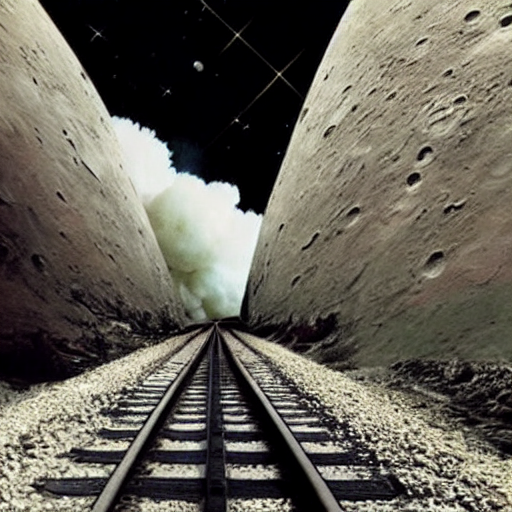

In [145]:
img0

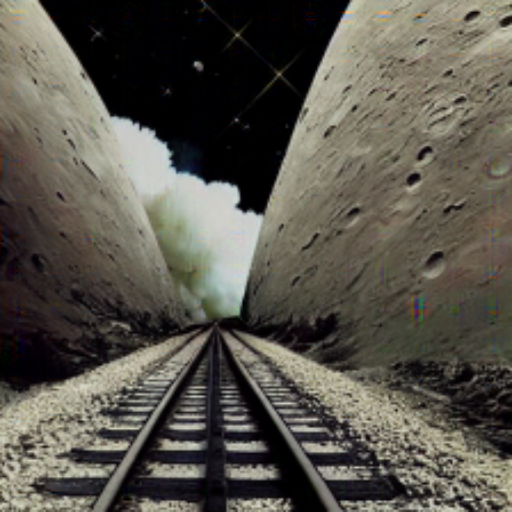

In [146]:
img1

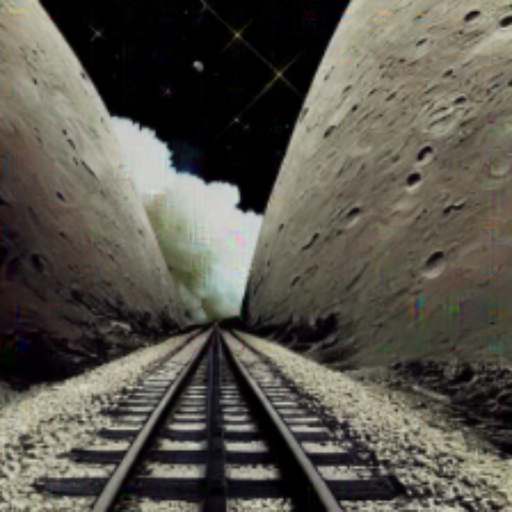

In [147]:
img2

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'images' is not defined